# Final Project 2 - Can a person be found online? 

## Part 1 - Product Design

### Problem Statement 

In certain situtations, it's required to be able to confidently output a single identifier for record. Many times there can be multiple identifiers per record and the goal is to pick the record that can most likely be found online. 

Given access to anonymous online identifiers and anonymous segment data, the goal is to be able to determine given a set of online identifiers, which will most likely to be seen online. 

Requirements around this algorithm are: 
* it is a blackbox to the consumer 
* deterministic (given the same set of identifiers, it will always return the same value) 

Simply put, given two different people, which one is more likely to be seen online? 

### Hypothesis

A bit challenging, considering I'm not supposed to have such visibility in the underlying data, but my guess would be that given access to over 250 segment fields, only a few would likely predict if someone can be found online.  

### Methods & Models 

This project can be seeen as both a classification problem and regression problem. To make matters simple in the beginning I will approach this as a classification problem, then will explore the regression aspects. 

When multiple identifiers are sent to the service each will be given a value 0 or 1 (can be found online or not), from there to deterministically always pick one, the service will always pick the lowest value identifier. 

### Availability of the Data / Explanation

Due to some privacy concerns, instead of downloading the data on a local machine, I'm using a wrapper library that access our RedShift client directly (using libraries like sqlalchemy and pandas.io.sql).

There are a couple datasets that will be used for this analysis, specifically 

**Segment data** 
This data is formatted as online_identifier, value_id, field_id. 

* online_identifier: the "person" variable 
* value_id: provider of the segment data (will not use, because cardinatility is ok) 
* field_id: cataloging logic for specific attribute associated to value_id 

The formatted listed above, will likely not gel well with pandas, so some preprocessing work will need to be done prior

**Online logs**
Very large dataset, but looking over a period of one month, this table will form another table that will contain 

* online_identifier: the "person" variable 
* found_online: yes or no 

More detailed descriptions can be found in the EDA section 


### Questions / Assumptions / Risk / Goals 

* Datasets on RS can be pretty large (multiple terabytes), so lots of heavy lifting will need to be done in RS, not Pandas 
* Assumption the "online logs" are the actual world, right now it's simply only the data that I have access to; this is a huge assumption. Many people are online, though they may not be in the online logs becaus they do not visit certain websites 
* Being able to connect to the dataset 

## Part 2 - Exploratory Data Analysis 

### Imports ! 

In [105]:
import functools
from itertools import cycle
from datetime import datetime, timedelta

from IPython.display import display

from sklearn import linear_model

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from is_py_utils.databases import create_default_redshift_engine # internal
from is_py_utils.corpuses import load_isp_corpus # internal 

### Connecting to RS & Creating useable Datasets 

In [81]:
red_engine = create_default_redshift_engine()

# tables I'm going to use 
# sammy.ga_all_pels -- collection of all individuals 
# sammy.ga_training_set_1_23_online_or_not -- contains 0 or 1 indicating if person can be found online 
# sammy.ga_pel_variable -- the real dataset 



In [18]:
populating_sammy_ga_all_pels = '''
insert into sammy.ga_all_pels
select distinct pel
from benchmark_audiences.ibe_segments;
'''

create_training_set_for_people_online = '''
insert into sammy.ga_training_set_1_23_online_or_not
select identifier_pel, 1
from spruce_logs.elmo_requests 
where log_conversion_time = '2017-01-23'
	and null_cookie is false 
	and accepts_cookie is true 
	and hashed_pin is not null
	and liveramp_arl_change_state in (0,2)
	and len(identifier_pel) = 49
group by identifier_pel;
'''

create_training_set_for_people_not_online = '''
insert into sammy.ga_training_set_1_23_online_or_not
select pel, 0
from sammy.ga_all_pels
where pel not in 
(
	select identifier_pel
	from spruce_logs.elmo_requests 
	where log_conversion_time >= '2016-12-01'
		and null_cookie is false 
		and accepts_cookie is true 
		and hashed_pin is not null
		and liveramp_arl_change_state in (0,2)
		and len(identifier_pel) = 49
	group by identifier_pel
)
limit 10000000;
'''

# script that creating this query can be found in the Appendix 
create_actual_data_model = '''
CREATE TABLE sammy.ga_pel_variable as 
(

select one.*, two.online
from 
(	
	select pel, sum(id_7290176) as id_7290176,sum(id_4973916) as id_4973916,sum(id_7290426) as id_7290426,sum(id_4972816) as id_4972816,sum(id_4973956) as id_4973956,sum(id_4974116) as id_4974116,sum(id_4977456) as id_4977456,sum(id_4973086) as id_4973086,sum(id_4977156) as id_4977156,sum(id_4977346) as id_4977346,sum(id_4972806) as id_4972806,sum(id_7290196) as id_7290196,sum(id_7291206) as id_7291206,sum(id_7311546) as id_7311546,sum(id_4977546) as id_4977546,sum(id_4972756) as id_4972756,sum(id_4977516) as id_4977516,sum(id_7290626) as id_7290626,sum(id_7289966) as id_7289966,sum(id_4972836) as id_4972836,sum(id_7290776) as id_7290776,sum(id_4977386) as id_4977386,sum(id_4977206) as id_4977206,sum(id_4972576) as id_4972576,sum(id_4977436) as id_4977436,sum(id_7290816) as id_7290816,sum(id_4973736) as id_4973736,sum(id_4973996) as id_4973996,sum(id_7290826) as id_7290826,sum(id_7290336) as id_7290336,sum(id_7311536) as id_7311536,sum(id_4977196) as id_4977196,sum(id_4973706) as id_4973706,sum(id_4973836) as id_4973836,sum(id_7290756) as id_7290756,sum(id_4974166) as id_4974166,sum(id_4977336) as id_4977336,sum(id_4973126) as id_4973126,sum(id_4977406) as id_4977406,sum(id_7289956) as id_7289956,sum(id_4972996) as id_4972996,sum(id_4980876) as id_4980876,sum(id_4980936) as id_4980936,sum(id_7291196) as id_7291196,sum(id_7290566) as id_7290566,sum(id_7290876) as id_7290876,sum(id_7290146) as id_7290146,sum(id_7290306) as id_7290306,sum(id_4973716) as id_4973716,sum(id_4972956) as id_4972956,sum(id_4973746) as id_4973746,sum(id_4972686) as id_4972686,sum(id_4974036) as id_4974036,sum(id_7290846) as id_7290846,sum(id_7311576) as id_7311576,sum(id_4973036) as id_4973036,sum(id_4973806) as id_4973806,sum(id_4973096) as id_4973096,sum(id_4977166) as id_4977166,sum(id_4977586) as id_4977586,sum(id_7290156) as id_7290156,sum(id_4973116) as id_4973116,sum(id_4972536) as id_4972536,sum(id_4980906) as id_4980906,sum(id_4973766) as id_4973766,sum(id_4972666) as id_4972666,sum(id_4972526) as id_4972526,sum(id_4973896) as id_4973896,sum(id_4973726) as id_4973726,sum(id_7289926) as id_7289926,sum(id_4973826) as id_4973826,sum(id_4973056) as id_4973056,sum(id_4974006) as id_4974006,sum(id_7290586) as id_7290586,sum(id_4980816) as id_4980816,sum(id_4974096) as id_4974096,sum(id_4977556) as id_4977556,sum(id_4973906) as id_4973906,sum(id_4973016) as id_4973016,sum(id_4978746) as id_4978746,sum(id_4974136) as id_4974136,sum(id_7290866) as id_7290866,sum(id_4972896) as id_4972896,sum(id_4972926) as id_4972926,sum(id_4977526) as id_4977526,sum(id_7290616) as id_7290616,sum(id_7290486) as id_7290486,sum(id_4972726) as id_4972726,sum(id_4973856) as id_4973856,sum(id_4972776) as id_4972776,sum(id_7290786) as id_7290786,sum(id_7291216) as id_7291216,sum(id_7291146) as id_7291146,sum(id_4980826) as id_4980826,sum(id_4973206) as id_4973206,sum(id_4974156) as id_4974156,sum(id_4980846) as id_4980846,sum(id_4972646) as id_4972646,sum(id_4972786) as id_4972786,sum(id_7291106) as id_7291106,sum(id_7290686) as id_7290686,sum(id_7290746) as id_7290746,sum(id_4972736) as id_4972736,sum(id_4973696) as id_4973696,sum(id_4973166) as id_4973166,sum(id_7290526) as id_7290526,sum(id_4974076) as id_4974076,sum(id_7290386) as id_7290386,sum(id_7290496) as id_7290496,sum(id_7290556) as id_7290556,sum(id_4973146) as id_4973146,sum(id_4974146) as id_4974146,sum(id_4972606) as id_4972606,sum(id_7290766) as id_7290766,sum(id_4977236) as id_4977236,sum(id_7290516) as id_7290516,sum(id_4980916) as id_4980916,sum(id_4972936) as id_4972936,sum(id_7311526) as id_7311526,sum(id_4977136) as id_4977136,sum(id_4973136) as id_4973136,sum(id_4980836) as id_4980836,sum(id_4977536) as id_4977536,sum(id_7289936) as id_7289936,sum(id_4974026) as id_4974026,sum(id_4977376) as id_4977376,sum(id_4973756) as id_4973756,sum(id_4973046) as id_4973046,sum(id_4972886) as id_4972886,sum(id_7290726) as id_7290726,sum(id_4973106) as id_4973106,sum(id_7291236) as id_7291236,sum(id_4972856) as id_4972856,sum(id_4974106) as id_4974106,sum(id_7311566) as id_7311566,sum(id_4972826) as id_4972826,sum(id_7290406) as id_7290406,sum(id_4972586) as id_4972586,sum(id_4973796) as id_4973796,sum(id_4974056) as id_4974056,sum(id_4972556) as id_4972556,sum(id_4973876) as id_4973876,sum(id_4974126) as id_4974126,sum(id_4973926) as id_4973926,sum(id_7290836) as id_7290836,sum(id_4977146) as id_4977146,sum(id_7290126) as id_7290126,sum(id_4973686) as id_4973686,sum(id_4977416) as id_4977416,sum(id_7290716) as id_7290716,sum(id_4972626) as id_4972626,sum(id_4973026) as id_4973026,sum(id_4977486) as id_4977486,sum(id_4972656) as id_4972656,sum(id_4980896) as id_4980896,sum(id_4973816) as id_4973816,sum(id_7290446) as id_7290446,sum(id_4977266) as id_4977266,sum(id_7290536) as id_7290536,sum(id_7311556) as id_7311556,sum(id_4980926) as id_4980926,sum(id_7290736) as id_7290736,sum(id_4974046) as id_4974046,sum(id_4974086) as id_4974086,sum(id_7290166) as id_7290166,sum(id_7290366) as id_7290366,sum(id_7290436) as id_7290436,sum(id_7291186) as id_7291186,sum(id_7291166) as id_7291166,sum(id_7290346) as id_7290346,sum(id_7291126) as id_7291126,sum(id_7290396) as id_7290396,sum(id_7290136) as id_7290136,sum(id_4972696) as id_4972696,sum(id_4977216) as id_4977216,sum(id_4972916) as id_4972916,sum(id_7290476) as id_7290476,sum(id_4977186) as id_4977186,sum(id_7290296) as id_7290296,sum(id_4973196) as id_4973196,sum(id_4973936) as id_4973936,sum(id_7290596) as id_7290596,sum(id_4977246) as id_4977246,sum(id_4973946) as id_4973946,sum(id_4977446) as id_4977446,sum(id_4973216) as id_4973216,sum(id_4972766) as id_4972766,sum(id_4972796) as id_4972796,sum(id_7290856) as id_7290856,sum(id_4972946) as id_4972946,sum(id_4972976) as id_4972976,sum(id_7290706) as id_7290706,sum(id_7289946) as id_7289946,sum(id_4977326) as id_4977326,sum(id_4980866) as id_4980866,sum(id_4977226) as id_4977226,sum(id_4980946) as id_4980946,sum(id_7290116) as id_7290116,sum(id_4972906) as id_4972906,sum(id_7290696) as id_7290696,sum(id_4972676) as id_4972676,sum(id_4977256) as id_4977256,sum(id_4972546) as id_4972546,sum(id_4972636) as id_4972636,sum(id_4977366) as id_4977366,sum(id_7291116) as id_7291116,sum(id_4973066) as id_4973066,sum(id_7289916) as id_7289916,sum(id_4973986) as id_4973986,sum(id_7290456) as id_7290456,sum(id_4978756) as id_4978756,sum(id_4973966) as id_4973966,sum(id_4972566) as id_4972566,sum(id_4973886) as id_4973886,sum(id_4972616) as id_4972616,sum(id_4972966) as id_4972966,sum(id_7290676) as id_7290676,sum(id_4973186) as id_4973186,sum(id_4973976) as id_4973976,sum(id_4972596) as id_4972596,sum(id_4973006) as id_4973006,sum(id_4977426) as id_4977426,sum(id_4972866) as id_4972866,sum(id_4974066) as id_4974066,sum(id_4972746) as id_4972746,sum(id_7290806) as id_7290806,sum(id_4977506) as id_4977506,sum(id_4973866) as id_4973866,sum(id_4972876) as id_4972876,sum(id_7291226) as id_7291226,sum(id_4977356) as id_4977356,sum(id_4973076) as id_4973076,sum(id_4977466) as id_4977466,sum(id_4972846) as id_4972846,sum(id_4973176) as id_4973176,sum(id_7290416) as id_7290416,sum(id_4977476) as id_4977476,sum(id_4977566) as id_4977566,sum(id_4980806) as id_4980806,sum(id_4980796) as id_4980796,sum(id_4977576) as id_4977576,sum(id_4977496) as id_4977496,sum(id_7311606) as id_7311606,sum(id_4972716) as id_4972716,sum(id_4973776) as id_4973776,sum(id_4973846) as id_4973846,sum(id_7311596) as id_7311596,sum(id_7290796) as id_7290796,sum(id_4973786) as id_4973786,sum(id_4972706) as id_4972706,sum(id_4977606) as id_4977606,sum(id_4977596) as id_4977596,sum(id_7291176) as id_7291176,sum(id_4980856) as id_4980856,sum(id_4977176) as id_4977176,sum(id_7291156) as id_7291156,sum(id_4977396) as id_4977396,sum(id_4972986) as id_4972986,sum(id_4980886) as id_4980886,sum(id_4973156) as id_4973156,sum(id_4977126) as id_4977126,sum(id_4977616) as id_4977616,sum(id_7311586) as id_7311586,sum(id_7289976) as id_7289976,sum(id_7291136) as id_7291136,sum(id_7290576) as id_7290576,sum(id_4974016) as id_4974016
	from
	(
		select pel, 
		case value_id when 7290176 then 1 else 0 end as id_7290176,
	case value_id when 4973916 then 1 else 0 end as id_4973916,
	case value_id when 7290426 then 1 else 0 end as id_7290426,
	case value_id when 4972816 then 1 else 0 end as id_4972816,
	case value_id when 4973956 then 1 else 0 end as id_4973956,
	case value_id when 4974116 then 1 else 0 end as id_4974116,
	case value_id when 4977456 then 1 else 0 end as id_4977456,
	case value_id when 4973086 then 1 else 0 end as id_4973086,
	case value_id when 4977156 then 1 else 0 end as id_4977156,
	case value_id when 4977346 then 1 else 0 end as id_4977346,
	case value_id when 4972806 then 1 else 0 end as id_4972806,
	case value_id when 7290196 then 1 else 0 end as id_7290196,
	case value_id when 7291206 then 1 else 0 end as id_7291206,
	case value_id when 7311546 then 1 else 0 end as id_7311546,
	case value_id when 4977546 then 1 else 0 end as id_4977546,
	case value_id when 4972756 then 1 else 0 end as id_4972756,
	case value_id when 4977516 then 1 else 0 end as id_4977516,
	case value_id when 7290626 then 1 else 0 end as id_7290626,
	case value_id when 7289966 then 1 else 0 end as id_7289966,
	case value_id when 4972836 then 1 else 0 end as id_4972836,
	case value_id when 7290776 then 1 else 0 end as id_7290776,
	case value_id when 4977386 then 1 else 0 end as id_4977386,
	case value_id when 4977206 then 1 else 0 end as id_4977206,
	case value_id when 4972576 then 1 else 0 end as id_4972576,
	case value_id when 4977436 then 1 else 0 end as id_4977436,
	case value_id when 7290816 then 1 else 0 end as id_7290816,
	case value_id when 4973736 then 1 else 0 end as id_4973736,
	case value_id when 4973996 then 1 else 0 end as id_4973996,
	case value_id when 7290826 then 1 else 0 end as id_7290826,
	case value_id when 7290336 then 1 else 0 end as id_7290336,
	case value_id when 7311536 then 1 else 0 end as id_7311536,
	case value_id when 4977196 then 1 else 0 end as id_4977196,
	case value_id when 4973706 then 1 else 0 end as id_4973706,
	case value_id when 4973836 then 1 else 0 end as id_4973836,
	case value_id when 7290756 then 1 else 0 end as id_7290756,
	case value_id when 4974166 then 1 else 0 end as id_4974166,
	case value_id when 4977336 then 1 else 0 end as id_4977336,
	case value_id when 4973126 then 1 else 0 end as id_4973126,
	case value_id when 4977406 then 1 else 0 end as id_4977406,
	case value_id when 7289956 then 1 else 0 end as id_7289956,
	case value_id when 4972996 then 1 else 0 end as id_4972996,
	case value_id when 4980876 then 1 else 0 end as id_4980876,
	case value_id when 4980936 then 1 else 0 end as id_4980936,
	case value_id when 7291196 then 1 else 0 end as id_7291196,
	case value_id when 7290566 then 1 else 0 end as id_7290566,
	case value_id when 7290876 then 1 else 0 end as id_7290876,
	case value_id when 7290146 then 1 else 0 end as id_7290146,
	case value_id when 7290306 then 1 else 0 end as id_7290306,
	case value_id when 4973716 then 1 else 0 end as id_4973716,
	case value_id when 4972956 then 1 else 0 end as id_4972956,
	case value_id when 4973746 then 1 else 0 end as id_4973746,
	case value_id when 4972686 then 1 else 0 end as id_4972686,
	case value_id when 4974036 then 1 else 0 end as id_4974036,
	case value_id when 7290846 then 1 else 0 end as id_7290846,
	case value_id when 7311576 then 1 else 0 end as id_7311576,
	case value_id when 4973036 then 1 else 0 end as id_4973036,
	case value_id when 4973806 then 1 else 0 end as id_4973806,
	case value_id when 4973096 then 1 else 0 end as id_4973096,
	case value_id when 4977166 then 1 else 0 end as id_4977166,
	case value_id when 4977586 then 1 else 0 end as id_4977586,
	case value_id when 7290156 then 1 else 0 end as id_7290156,
	case value_id when 4973116 then 1 else 0 end as id_4973116,
	case value_id when 4972536 then 1 else 0 end as id_4972536,
	case value_id when 4980906 then 1 else 0 end as id_4980906,
	case value_id when 4973766 then 1 else 0 end as id_4973766,
	case value_id when 4972666 then 1 else 0 end as id_4972666,
	case value_id when 4972526 then 1 else 0 end as id_4972526,
	case value_id when 4973896 then 1 else 0 end as id_4973896,
	case value_id when 4973726 then 1 else 0 end as id_4973726,
	case value_id when 7289926 then 1 else 0 end as id_7289926,
	case value_id when 4973826 then 1 else 0 end as id_4973826,
	case value_id when 4973056 then 1 else 0 end as id_4973056,
	case value_id when 4974006 then 1 else 0 end as id_4974006,
	case value_id when 7290586 then 1 else 0 end as id_7290586,
	case value_id when 4980816 then 1 else 0 end as id_4980816,
	case value_id when 4974096 then 1 else 0 end as id_4974096,
	case value_id when 4977556 then 1 else 0 end as id_4977556,
	case value_id when 4973906 then 1 else 0 end as id_4973906,
	case value_id when 4973016 then 1 else 0 end as id_4973016,
	case value_id when 4978746 then 1 else 0 end as id_4978746,
	case value_id when 4974136 then 1 else 0 end as id_4974136,
	case value_id when 7290866 then 1 else 0 end as id_7290866,
	case value_id when 4972896 then 1 else 0 end as id_4972896,
	case value_id when 4972926 then 1 else 0 end as id_4972926,
	case value_id when 4977526 then 1 else 0 end as id_4977526,
	case value_id when 7290616 then 1 else 0 end as id_7290616,
	case value_id when 7290486 then 1 else 0 end as id_7290486,
	case value_id when 4972726 then 1 else 0 end as id_4972726,
	case value_id when 4973856 then 1 else 0 end as id_4973856,
	case value_id when 4972776 then 1 else 0 end as id_4972776,
	case value_id when 7290786 then 1 else 0 end as id_7290786,
	case value_id when 7291216 then 1 else 0 end as id_7291216,
	case value_id when 7291146 then 1 else 0 end as id_7291146,
	case value_id when 4980826 then 1 else 0 end as id_4980826,
	case value_id when 4973206 then 1 else 0 end as id_4973206,
	case value_id when 4974156 then 1 else 0 end as id_4974156,
	case value_id when 4980846 then 1 else 0 end as id_4980846,
	case value_id when 4972646 then 1 else 0 end as id_4972646,
	case value_id when 4972786 then 1 else 0 end as id_4972786,
	case value_id when 7291106 then 1 else 0 end as id_7291106,
	case value_id when 7290686 then 1 else 0 end as id_7290686,
	case value_id when 7290746 then 1 else 0 end as id_7290746,
	case value_id when 4972736 then 1 else 0 end as id_4972736,
	case value_id when 4973696 then 1 else 0 end as id_4973696,
	case value_id when 4973166 then 1 else 0 end as id_4973166,
	case value_id when 7290526 then 1 else 0 end as id_7290526,
	case value_id when 4974076 then 1 else 0 end as id_4974076,
	case value_id when 7290386 then 1 else 0 end as id_7290386,
	case value_id when 7290496 then 1 else 0 end as id_7290496,
	case value_id when 7290556 then 1 else 0 end as id_7290556,
	case value_id when 4973146 then 1 else 0 end as id_4973146,
	case value_id when 4974146 then 1 else 0 end as id_4974146,
	case value_id when 4972606 then 1 else 0 end as id_4972606,
	case value_id when 7290766 then 1 else 0 end as id_7290766,
	case value_id when 4977236 then 1 else 0 end as id_4977236,
	case value_id when 7290516 then 1 else 0 end as id_7290516,
	case value_id when 4980916 then 1 else 0 end as id_4980916,
	case value_id when 4972936 then 1 else 0 end as id_4972936,
	case value_id when 7311526 then 1 else 0 end as id_7311526,
	case value_id when 4977136 then 1 else 0 end as id_4977136,
	case value_id when 4973136 then 1 else 0 end as id_4973136,
	case value_id when 4980836 then 1 else 0 end as id_4980836,
	case value_id when 4977536 then 1 else 0 end as id_4977536,
	case value_id when 7289936 then 1 else 0 end as id_7289936,
	case value_id when 4974026 then 1 else 0 end as id_4974026,
	case value_id when 4977376 then 1 else 0 end as id_4977376,
	case value_id when 4973756 then 1 else 0 end as id_4973756,
	case value_id when 4973046 then 1 else 0 end as id_4973046,
	case value_id when 4972886 then 1 else 0 end as id_4972886,
	case value_id when 7290726 then 1 else 0 end as id_7290726,
	case value_id when 4973106 then 1 else 0 end as id_4973106,
	case value_id when 7291236 then 1 else 0 end as id_7291236,
	case value_id when 4972856 then 1 else 0 end as id_4972856,
	case value_id when 4974106 then 1 else 0 end as id_4974106,
	case value_id when 7311566 then 1 else 0 end as id_7311566,
	case value_id when 4972826 then 1 else 0 end as id_4972826,
	case value_id when 7290406 then 1 else 0 end as id_7290406,
	case value_id when 4972586 then 1 else 0 end as id_4972586,
	case value_id when 4973796 then 1 else 0 end as id_4973796,
	case value_id when 4974056 then 1 else 0 end as id_4974056,
	case value_id when 4972556 then 1 else 0 end as id_4972556,
	case value_id when 4973876 then 1 else 0 end as id_4973876,
	case value_id when 4974126 then 1 else 0 end as id_4974126,
	case value_id when 4973926 then 1 else 0 end as id_4973926,
	case value_id when 7290836 then 1 else 0 end as id_7290836,
	case value_id when 4977146 then 1 else 0 end as id_4977146,
	case value_id when 7290126 then 1 else 0 end as id_7290126,
	case value_id when 4973686 then 1 else 0 end as id_4973686,
	case value_id when 4977416 then 1 else 0 end as id_4977416,
	case value_id when 7290716 then 1 else 0 end as id_7290716,
	case value_id when 4972626 then 1 else 0 end as id_4972626,
	case value_id when 4973026 then 1 else 0 end as id_4973026,
	case value_id when 4977486 then 1 else 0 end as id_4977486,
	case value_id when 4972656 then 1 else 0 end as id_4972656,
	case value_id when 4980896 then 1 else 0 end as id_4980896,
	case value_id when 4973816 then 1 else 0 end as id_4973816,
	case value_id when 7290446 then 1 else 0 end as id_7290446,
	case value_id when 4977266 then 1 else 0 end as id_4977266,
	case value_id when 7290536 then 1 else 0 end as id_7290536,
	case value_id when 7311556 then 1 else 0 end as id_7311556,
	case value_id when 4980926 then 1 else 0 end as id_4980926,
	case value_id when 7290736 then 1 else 0 end as id_7290736,
	case value_id when 4974046 then 1 else 0 end as id_4974046,
	case value_id when 4974086 then 1 else 0 end as id_4974086,
	case value_id when 7290166 then 1 else 0 end as id_7290166,
	case value_id when 7290366 then 1 else 0 end as id_7290366,
	case value_id when 7290436 then 1 else 0 end as id_7290436,
	case value_id when 7291186 then 1 else 0 end as id_7291186,
	case value_id when 7291166 then 1 else 0 end as id_7291166,
	case value_id when 7290346 then 1 else 0 end as id_7290346,
	case value_id when 7291126 then 1 else 0 end as id_7291126,
	case value_id when 7290396 then 1 else 0 end as id_7290396,
	case value_id when 7290136 then 1 else 0 end as id_7290136,
	case value_id when 4972696 then 1 else 0 end as id_4972696,
	case value_id when 4977216 then 1 else 0 end as id_4977216,
	case value_id when 4972916 then 1 else 0 end as id_4972916,
	case value_id when 7290476 then 1 else 0 end as id_7290476,
	case value_id when 4977186 then 1 else 0 end as id_4977186,
	case value_id when 7290296 then 1 else 0 end as id_7290296,
	case value_id when 4973196 then 1 else 0 end as id_4973196,
	case value_id when 4973936 then 1 else 0 end as id_4973936,
	case value_id when 7290596 then 1 else 0 end as id_7290596,
	case value_id when 4977246 then 1 else 0 end as id_4977246,
	case value_id when 4973946 then 1 else 0 end as id_4973946,
	case value_id when 4977446 then 1 else 0 end as id_4977446,
	case value_id when 4973216 then 1 else 0 end as id_4973216,
	case value_id when 4972766 then 1 else 0 end as id_4972766,
	case value_id when 4972796 then 1 else 0 end as id_4972796,
	case value_id when 7290856 then 1 else 0 end as id_7290856,
	case value_id when 4972946 then 1 else 0 end as id_4972946,
	case value_id when 4972976 then 1 else 0 end as id_4972976,
	case value_id when 7290706 then 1 else 0 end as id_7290706,
	case value_id when 7289946 then 1 else 0 end as id_7289946,
	case value_id when 4977326 then 1 else 0 end as id_4977326,
	case value_id when 4980866 then 1 else 0 end as id_4980866,
	case value_id when 4977226 then 1 else 0 end as id_4977226,
	case value_id when 4980946 then 1 else 0 end as id_4980946,
	case value_id when 7290116 then 1 else 0 end as id_7290116,
	case value_id when 4972906 then 1 else 0 end as id_4972906,
	case value_id when 7290696 then 1 else 0 end as id_7290696,
	case value_id when 4972676 then 1 else 0 end as id_4972676,
	case value_id when 4977256 then 1 else 0 end as id_4977256,
	case value_id when 4972546 then 1 else 0 end as id_4972546,
	case value_id when 4972636 then 1 else 0 end as id_4972636,
	case value_id when 4977366 then 1 else 0 end as id_4977366,
	case value_id when 7291116 then 1 else 0 end as id_7291116,
	case value_id when 4973066 then 1 else 0 end as id_4973066,
	case value_id when 7289916 then 1 else 0 end as id_7289916,
	case value_id when 4973986 then 1 else 0 end as id_4973986,
	case value_id when 7290456 then 1 else 0 end as id_7290456,
	case value_id when 4978756 then 1 else 0 end as id_4978756,
	case value_id when 4973966 then 1 else 0 end as id_4973966,
	case value_id when 4972566 then 1 else 0 end as id_4972566,
	case value_id when 4973886 then 1 else 0 end as id_4973886,
	case value_id when 4972616 then 1 else 0 end as id_4972616,
	case value_id when 4972966 then 1 else 0 end as id_4972966,
	case value_id when 7290676 then 1 else 0 end as id_7290676,
	case value_id when 4973186 then 1 else 0 end as id_4973186,
	case value_id when 4973976 then 1 else 0 end as id_4973976,
	case value_id when 4972596 then 1 else 0 end as id_4972596,
	case value_id when 4973006 then 1 else 0 end as id_4973006,
	case value_id when 4977426 then 1 else 0 end as id_4977426,
	case value_id when 4972866 then 1 else 0 end as id_4972866,
	case value_id when 4974066 then 1 else 0 end as id_4974066,
	case value_id when 4972746 then 1 else 0 end as id_4972746,
	case value_id when 7290806 then 1 else 0 end as id_7290806,
	case value_id when 4977506 then 1 else 0 end as id_4977506,
	case value_id when 4973866 then 1 else 0 end as id_4973866,
	case value_id when 4972876 then 1 else 0 end as id_4972876,
	case value_id when 7291226 then 1 else 0 end as id_7291226,
	case value_id when 4977356 then 1 else 0 end as id_4977356,
	case value_id when 4973076 then 1 else 0 end as id_4973076,
	case value_id when 4977466 then 1 else 0 end as id_4977466,
	case value_id when 4972846 then 1 else 0 end as id_4972846,
	case value_id when 4973176 then 1 else 0 end as id_4973176,
	case value_id when 7290416 then 1 else 0 end as id_7290416,
	case value_id when 4977476 then 1 else 0 end as id_4977476,
	case value_id when 4977566 then 1 else 0 end as id_4977566,
	case value_id when 4980806 then 1 else 0 end as id_4980806,
	case value_id when 4980796 then 1 else 0 end as id_4980796,
	case value_id when 4977576 then 1 else 0 end as id_4977576,
	case value_id when 4977496 then 1 else 0 end as id_4977496,
	case value_id when 7311606 then 1 else 0 end as id_7311606,
	case value_id when 4972716 then 1 else 0 end as id_4972716,
	case value_id when 4973776 then 1 else 0 end as id_4973776,
	case value_id when 4973846 then 1 else 0 end as id_4973846,
	case value_id when 7311596 then 1 else 0 end as id_7311596,
	case value_id when 7290796 then 1 else 0 end as id_7290796,
	case value_id when 4973786 then 1 else 0 end as id_4973786,
	case value_id when 4972706 then 1 else 0 end as id_4972706,
	case value_id when 4977606 then 1 else 0 end as id_4977606,
	case value_id when 4977596 then 1 else 0 end as id_4977596,
	case value_id when 7291176 then 1 else 0 end as id_7291176,
	case value_id when 4980856 then 1 else 0 end as id_4980856,
	case value_id when 4977176 then 1 else 0 end as id_4977176,
	case value_id when 7291156 then 1 else 0 end as id_7291156,
	case value_id when 4977396 then 1 else 0 end as id_4977396,
	case value_id when 4972986 then 1 else 0 end as id_4972986,
	case value_id when 4980886 then 1 else 0 end as id_4980886,
	case value_id when 4973156 then 1 else 0 end as id_4973156,
	case value_id when 4977126 then 1 else 0 end as id_4977126,
	case value_id when 4977616 then 1 else 0 end as id_4977616,
	case value_id when 7311586 then 1 else 0 end as id_7311586,
	case value_id when 7289976 then 1 else 0 end as id_7289976,
	case value_id when 7291136 then 1 else 0 end as id_7291136,
	case value_id when 7290576 then 1 else 0 end as id_7290576,
	case value_id when 4974016 then 1 else 0 end as id_4974016
		from (
			select *
			from benchmark_audiences.ibe_segments
			where pel in (
				select distinct pel 
				from sammy.ga_training_set_1_23_online_or_not
			)
		)
	)
	group by pel
) one 
inner join sammy.ga_training_set_1_23_online_or_not two on one.pel = two.pel 
)
'''

In [83]:
query = '''
select *
from sammy.ga_pel_variable
order by random()
limit 1000
'''

In [84]:
data_set = pd.read_sql_query(query, red_engine)


In [85]:
data_set.set_index(['pel'])

data_set.head()


,pel,id_7290176,id_4973916,id_7290426,id_4972816,id_4973956,id_4974116,id_4977456,id_4973086,id_4977156,...,id_4980886,id_4973156,id_4977126,id_4977616,id_7311586,id_7289976,id_7291136,id_7290576,id_4974016,online
0,XY1005cZFnzzpIReahxRK8nTeGBHIJkbs2wWFhPHtrW5l30tI,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,XY1005Mto_i5bsqvk_s1pkmuwxUCGEGsrWMYG369x6kdFvQYc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,XY1005Yi1WKJC9LETAlGd-zH_SVxF4eqK1316lw4Y0FmOiXv4,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,XY1005D8uGLP5oGTGLK7WQM76XIwJqKLSCNDEiSm-mNRCB69k,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,XY1005wmsjbCH0Ybb_sxqlGo-sZZ9xpKKRieZ7vvfCDvVWAF4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### EDA 

In [86]:
data_set.describe()

,id_7290176,id_4973916,id_7290426,id_4972816,id_4973956,id_4974116,id_4977456,id_4973086,id_4977156,id_4977346,...,id_4980886,id_4973156,id_4977126,id_4977616,id_7311586,id_7289976,id_7291136,id_7290576,id_4974016,online
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.049000,0.006000,0.222000,0.010000,0.006000,0.005000,0.095000,0.05800,0.19300,0.184000,...,0.076000,0.008000,0.313000,0.028000,0.110000,0.081000,0.113000,0.074000,0.120000,0.275000
std,0.215976,0.077266,0.415799,0.099549,0.077266,0.070569,0.293362,0.23386,0.39485,0.387678,...,0.265131,0.089129,0.463946,0.165055,0.313046,0.272972,0.316751,0.261902,0.325124,0.446738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### On average how many segments does a person belong to? 

In [87]:
data_set.sum(axis=1).mean()

19.357

#### Which segments are the largest? 

In [88]:
data_set.sum(axis=0).sort_values(ascending=False).head(15)

pel           XY1005cZFnzzpIReahxRK8nTeGBHIJkbs2wWFhPHtrW5l3...
id_4977426                                                  722
id_7291186                                                  722
id_4977406                                                  564
id_4977326                                                  556
id_4978746                                                  458
id_4978756                                                  453
id_4977386                                                  446
id_4977336                                                  444
id_4977396                                                  436
id_7290496                                                  352
id_4977126                                                  313
id_7289956                                                  287
id_7289926                                                  287
id_4977416                                                  278
dtype: object

Seems like there are many segments that capture more than half the audience. 

#### Are there any correlations between some of the larger segments? 

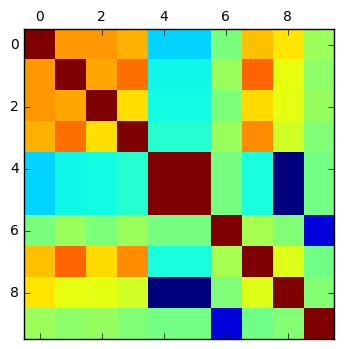

In [89]:
top_10_segments_data = data_set[['id_4977326','id_7290496','id_4977396','id_7289956','id_4977426','id_7291186','id_4978756','id_7289926','id_4977416','id_4978746']]

corr = top_10_segments_data.corr()

corr
plt.matshow(corr)

Even though I do not know the real value of the underlying data, I'm still able to make some inferences. For example, my guess is id_4977426 and id_7291186, both repsresent the same segment (perhaps gender)? id_4977416 seems to be a contracdictory one. 

#### Can we start making some guesses about people who are online / offline? 

In [92]:
data_set[data_set.online == 1].sum(axis=1).mean() # person who is online - 25.214545454545455
data_set[data_set.online == 0].sum(axis=1).mean() # person who is offline - 17.135172413793104

17.135172413793104

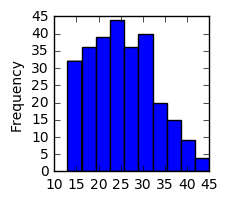

In [96]:
data_set[data_set.online == 1].sum(axis=1).plot(kind = 'hist', figsize = (2, 2))

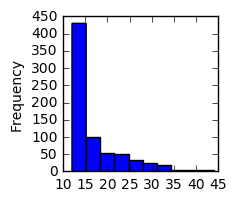

In [97]:
data_set[data_set.online == 0].sum(axis=1).plot(kind = 'hist', figsize = (2, 2))

## Part 3 - Data Science

In [100]:
X = data_set[ ['id_4977326','id_7290496','id_4977396','id_7289956','id_4977426','id_7291186','id_4978756','id_7289926','id_4977416','id_4978746'] ]
X

,id_4977326,id_7290496,id_4977396,id_7289956,id_4977426,id_7291186,id_4978756,id_7289926,id_4977416,id_4978746
0,1,1,1,1,1,1,0,1,0,1
1,1,1,1,1,1,1,0,0,0,1
2,0,0,0,0,1,1,1,0,0,0
3,1,0,1,0,1,1,1,1,0,0
4,1,0,1,1,0,0,1,1,1,0
5,1,0,1,1,0,0,1,0,1,0
6,0,0,0,0,1,1,1,0,0,0
7,1,1,1,0,0,0,0,1,1,1
8,1,0,0,1,0,0,0,0,1,1
9,1,1,1,1,1,1,0,1,0,1


In [103]:
c = data_set.online
c

0      0
1      1
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     1
11     0
12     0
13     0
14     0
15     1
16     0
17     0
18     0
19     1
20     0
21     0
22     0
23     1
24     0
25     0
26     0
27     0
28     0
29     0
      ..
970    0
971    1
972    0
973    0
974    0
975    0
976    1
977    0
978    1
979    1
980    0
981    0
982    0
983    0
984    0
985    0
986    0
987    1
988    0
989    0
990    1
991    0
992    0
993    0
994    0
995    0
996    0
997    1
998    1
999    0
Name: online, dtype: int64

In [106]:
logistic_model = linear_model.LogisticRegression().fit(X, c)

In [107]:
print logistic_model.coef_
print logistic_model.intercept_

[[ 0.64577239  1.05642687  0.08124649  0.41431364 -0.7947868  -0.7947868
   1.11705438  0.45945156 -1.08311876  1.19462232]]
[-1.87790556]


## Next Steps 

* Definitely need to think how the training set will be created. 
* One idea is we start from the beginning, and constantly add more data each day. 
* Really leaning on RedShift's "random" selecion -- I should probably use a proper way, to ensure everything is actually random 
* logistic modeling 

## Appendix 

Code for creating the lengthly query above 

In [14]:
data = [
7290176,4973916,7290426,4972816,4973956,4974116,4977456,
4973086,
4977156,
4977346,
4972806,
7290196,
7291206,
7311546,
4977546,
4972756,
4977516,
7290626,
7289966,
4972836,
7290776,
4977386,
4977206,
4972576,
4977436,
7290816,
4973736,
4973996,
7290826,
7290336,
7311536,
4977196,
4973706,
4973836,
7290756,
4974166,
4977336,
4973126,
4977406,
7289956,
4972996,
4980876,
4980936,
7291196,
7290566,
7290876,
7290146,
7290306,
4973716,
4972956,
4973746,
4972686,
4974036,
7290846,
7311576,
4973036,
4973806,
4973096,
4977166,
4977586,
7290156,
4973116,
4972536,
4980906,
4973766,
4972666,
4972526,
4973896,
4973726,
7289926,
4973826,
4973056,
4974006,
7290586,
4980816,
4974096,
4977556,
4973906,
4973016,
4978746,
4974136,
7290866,
4972896,
4972926,
4977526,
7290616,
7290486,
4972726,
4973856,
4972776,
7290786,
7291216,
7291146,
4980826,
4973206,
4974156,
4980846,
4972646,
4972786,
7291106,
7290686,
7290746,
4972736,
4973696,
4973166,
7290526,
4974076,
7290386,
7290496,
7290556,
4973146,
4974146,
4972606,
7290766,
4977236,
7290516,
4980916,
4972936,
7311526,
4977136,
4973136,
4980836,
4977536,
7289936,
4974026,
4977376,
4973756,
4973046,
4972886,
7290726,
4973106,
7291236,
4972856,
4974106,
7311566,
4972826,
7290406,
4972586,
4973796,
4974056,
4972556,
4973876,
4974126,
4973926,
7290836,
4977146,
7290126,
4973686,
4977416,
7290716,
4972626,
4973026,
4977486,
4972656,
4980896,
4973816,
7290446,
4977266,
7290536,
7311556,
4980926,
7290736,
4974046,
4974086,
7290166,
7290366,
7290436,
7291186,
7291166,
7290346,
7291126,
7290396,
7290136,
4972696,
4977216,
4972916,
7290476,
4977186,
7290296,
4973196,
4973936,
7290596,
4977246,
4973946,
4977446,
4973216,
4972766,
4972796,
7290856,
4972946,
4972976,
7290706,
7289946,
4977326,
4980866,
4977226,
4980946,
7290116,
4972906,
7290696,
4972676,
4977256,
4972546,
4972636,
4977366,
7291116,
4973066,
7289916,
4973986,
7290456,
4978756,
4973966,
4972566,
4973886,
4972616,
4972966,
7290676,
4973186,
4973976,
4972596,
4973006,
4977426,
4972866,
4974066,
4972746,
7290806,
4977506,
4973866,
4972876,
7291226,
4977356,
4973076,
4977466,
4972846,
4973176,
7290416,
4977476,
4977566,
4980806,
4980796,
4977576,
4977496,
7311606,
4972716,
4973776,
4973846,
7311596,
7290796,
4973786,
4972706,
4977606,
4977596,
7291176,
4980856,
4977176,
7291156,
4977396,
4972986,
4980886,
4973156,
4977126,
4977616,
7311586,
7289976,
7291136,
7290576,
4974016]



for x in data: 
	print "case value_id when " + str(x) +  " then 1 else 0 end as id_" + str(x) + ","


top_line = ""

for x in data: 
	top_line += "sum(id_" + str(x) + ") as id_" + str(x) + "," # use pca; foward & backward || Confusion Matrix || it's important to get rid of multicolinearity || split the model

IndentationError: expected an indented block (<ipython-input-14-0c1bbdf0de70>, line 276)